# Movie Recommendation System

**Recommendation System** is a filtration program whose prime goal is to predict the “rating” or “preference” of a user towards a domain-specific item or item. In our case, this domain-specific item is a movie, therefore the main focus of our recommendation system is to filter and predict only those movies which a user would prefer given some data about the user him or herself.

The Filtration is done based on data provided about items.The algorithm recommends products that are similar to the ones that a user has liked in the past.

For Eg: If a user likes some thriller movie and he gives some positive response then ths recommendation system helps the user to find the movie in the same genre with almost same ratings and response

The basic idea here is to find users that have similar past preference patterns as the user ‘A’ has had and then recommending him or her items liked by those similar users which ‘A’ has not encountered yet. This is achieved by making a matrix of items each user has rated/viewed/liked/clicked depending upon the task at hand, and then computing the similarity score between the users and finally recommending items that the concerned user isn’t aware of but users similar to him/her are and liked it.

**For example**: if the user ‘A’ likes ‘Batman Begins’, ‘Justice League’ and ‘The Avengers’ while the user ‘B’ likes ‘Batman Begins’, ‘Justice League’ and ‘Thor’ then they have similar interests because we know that these movies belong to the super-hero genre. So, there is a high probability that the user ‘A’ would like ‘Thor’ and the user ‘B’ would like The Avengers’.

# Getting the data up and running

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Here, we can see that **userId 1** has watched **movieId 1 & 3** and rated both of them **4.0** but has not rated **movieId 2** at all. This interpretation is harder to extract from this dataframe. Therefore, to make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [5]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


**Impute NaN with 0 to make things understandable for the algorithm and also making the data more eye-soothing.**

In [6]:
final_dataset.fillna(0, inplace=True)

In [7]:
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


OK!!! Here comes the main problem we just can't take everyone's reviews into consideration because a person might seen only that particular movie in that genre or he might be fan of that particular hero and might given a good ratings.

So, I ahve made a decision to seggregate the ratings by keeping conditions like:

* To qualify a movie, a minimum of 10 users should have voted a movie.
* To qualify a user, a minimum of 50 movies should have voted by the user.

This method also helps me remove extra or unwanted noise in the dataset. In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users.

In [8]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

### Let's vizualize it

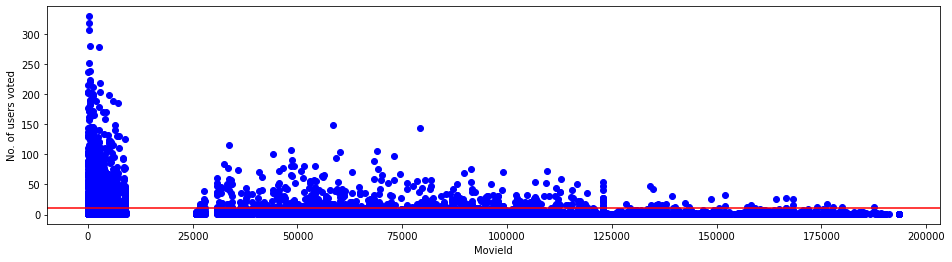

In [10]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='blue')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [11]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]
final_dataset.shape

(2121, 610)

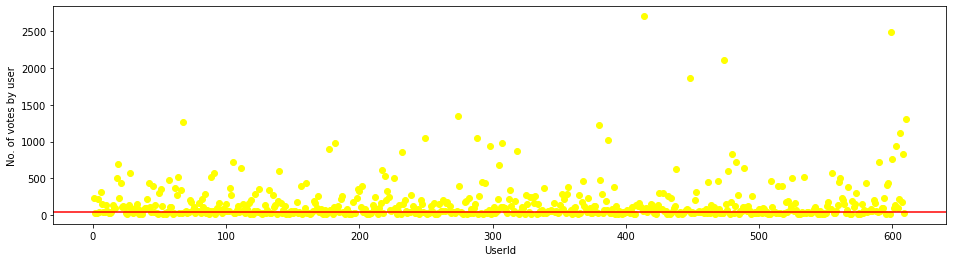

In [12]:
fig, axes = plt.subplots(1,1, figsize=(16,4))
plt.scatter(no_movies_voted.index, no_movies_voted, color = 'yellow')
plt.axhline(y=50, color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [15]:
final_dataset = final_dataset.loc[:,no_movies_voted[no_movies_voted>50].index]
final_dataset.shape

(2121, 378)

In [16]:
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 We are using only a small dataset but for the original large dataset of movie lens which has more than 100000 features, our system may run out of computational resources when that is feed to the model. To reduce the sparsity we use the csr_matrix function from the scipy library.

In [17]:
csr_data = csr_matrix(final_dataset.values)
csr_data

<2121x378 sparse matrix of type '<class 'numpy.float64'>'
	with 72893 stored elements in Compressed Sparse Row format>

In [18]:
final_dataset.reset_index(inplace=True)
final_dataset

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2117,176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2118,177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,179819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## We use KNN as our Machine Learning Model algorithm

In [19]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

## FInal Step

In [28]:
def recommend_me_a_movie(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [51]:
recommend_me_a_movie(input().title())

spider-man


,Title,Distance
1,"Bourne Identity, The (2002)",0.343779
2,"Matrix Reloaded, The (2003)",0.339360
3,"Lord of the Rings: The Two Towers, The (2002)",0.336474
4,Pirates of the Caribbean: The Curse of the Bla...,0.330627
5,"Lord of the Rings: The Fellowship of the Ring,...",0.323939
6,X-Men (2000),0.314977
7,X2: X-Men United (2003),0.310659
8,Minority Report (2002),0.299829
9,Star Wars: Episode II - Attack of the Clones (...,0.264826
10,Spider-Man 2 (2004),0.257294
